# ResNet Ablation Study

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

## Residual Block - 34,  50

In [108]:
# function for building VGG Block

def build_residual_block(resnet_num,
                    input_layer,
                    num_cnn=2, 
                    channel=64,
                    block_num=1,
                   ):
    # 입력 레이어
    x = input_layer
    shortcut = input_layer
    
    if resnet_num == 34:

        # CNN 레이어
        for cnn_num in range(num_cnn):

            if cnn_num == 0 and channel != 64:
                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    kernel_initializer='he_normal',
                    padding='same',
                    strides = 2,
                )(x)    
                x = keras.layers.BatchNormalization()(x)         
                x = keras.layers.Activation("relu")(x)

                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    kernel_initializer='he_normal',
                    padding='same',
                )(x)    
                x = keras.layers.BatchNormalization()(x)

                shortcut = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(1,1),
                    kernel_initializer='he_normal',
                    padding='same',
                    strides=2,
                )(shortcut) 
                shortcut = keras.layers.BatchNormalization()(shortcut)

                x = x + shortcut
                x = keras.layers.Activation("relu")(x)

            else:
                for num_block in range(2):
                    x = keras.layers.Conv2D(
                        filters=channel,
                        kernel_size=(3,3),
                        kernel_initializer='he_normal',
                        padding='same',
                    )(x)    
                    x = keras.layers.BatchNormalization()(x)

                    if num_block != 1:

                        x = keras.layers.Activation("relu")(x)
                    else:
                        x = x + shortcut
                        x = keras.layers.Activation("relu")(x)
    
    
    
    
    elif resnet_num == 50:
        for cnn_num in range(num_cnn):
            if cnn_num == 0 and channel != 64:
                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(1,1),
                    kernel_initializer='he_normal',
                    padding='same',
                    strides = 2,
                )(x)    
                x = keras.layers.BatchNormalization()(x)         
                x = keras.layers.Activation("relu")(x)

                
                
                for num_block, ker_size in enumerate([3,1]):
                    
                    if num_block != 1:                
                        x = keras.layers.Conv2D(
                            filters=channel,
                            kernel_size=(ker_size, ker_size),
                            kernel_initializer='he_normal',
                            padding='same',
                        )(x)    
                        x = keras.layers.BatchNormalization()(x)
                        x = keras.layers.Activation("relu")(x)
                    else:
                        x = keras.layers.Conv2D(
                            filters=channel*4,
                            kernel_size=(ker_size, ker_size),
                            kernel_initializer='he_normal',
                            padding='same',
                        )(x)    
                        x = keras.layers.BatchNormalization()(x)                       

                        shortcut = keras.layers.Conv2D(
                            filters=channel*4,
                            kernel_size=(1,1),
                            kernel_initializer='he_normal',
                            padding='same',
                            strides = 2
                        )(shortcut) 
                        shortcut = keras.layers.BatchNormalization()(shortcut)

                        x = x + shortcut
                        x = keras.layers.Activation("relu")(x)

            else:
                for num_block, ker_size in enumerate([1,3,1]): 
                    
                    if num_block != 2:
                        x = keras.layers.Conv2D(
                            filters=channel,
                            kernel_size=(ker_size, ker_size),
                            kernel_initializer='he_normal',
                            padding='same',
                        )(x)    
                        x = keras.layers.BatchNormalization()(x)
                        x = keras.layers.Activation("relu")(x)
                    else:
                        x = keras.layers.Conv2D(
                            filters=channel*4,
                            kernel_size=(ker_size, ker_size),
                            kernel_initializer='he_normal',
                            padding='same',
                        )(x)    
                        x = keras.layers.BatchNormalization()(x)  
                        
                        shortcut = keras.layers.Conv2D(
                            filters=channel*4,
                            kernel_size=(1,1),
                            kernel_initializer='he_normal',
                            padding='same',
                        )(shortcut) 
                        shortcut = keras.layers.BatchNormalization()(shortcut)
                        
                        x = x + shortcut
                        x = keras.layers.Activation("relu")(x)    


    return x

## Build ResNet - 34,50

In [109]:
# VGG 모델 자체를 생성하는 함수입니다.
def build_resnet(resnet_num,
                  input_shape=(224,224,3),
                  num_cnn_list=[3,4,6,3],
                  channel_list=[64,128,256,512],
                  num_classes=10
                  ):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    
    
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    output = keras.layers.Conv2D(
        filters=64,
        kernel_size=(7,7),
        kernel_initializer='he_normal',
        padding='same',
        strides= 2,
    )(output)    
    output = keras.layers.BatchNormalization()(output)
    output = keras.layers.Activation("relu")(output)
    
    output = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
    )(output)
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_residual_block(
            resnet_num,
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )

    output = keras.layers.AveragePooling2D(pool_size=(1,1))(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)

    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model


In [110]:
# resnet34 = build_resnet(34)

# resnet34.summary()

In [111]:
resnet34 = build_resnet(34)

resnet34.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_265 (Conv2D)             (None, 112, 112, 64) 9472        input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_265 (BatchN (None, 112, 112, 64) 256         conv2d_265[0][0]                 
__________________________________________________________________________________________________
activation_246 (Activation)     (None, 112, 112, 64) 0           batch_normalization_265[0][0]    
____________________________________________________________________________________________

In [112]:
resnet50 = build_resnet(50)

resnet50.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_301 (Conv2D)             (None, 112, 112, 64) 9472        input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_301 (BatchN (None, 112, 112, 64) 256         conv2d_301[0][0]                 
__________________________________________________________________________________________________
activation_279 (Activation)     (None, 112, 112, 64) 0           batch_normalization_301[0][0]    
____________________________________________________________________________________________

## Plain Network 34, 50

In [113]:
# function for building VGG Block

def build_plain_network(resnet_num,
                    input_layer,
                    num_cnn=2, 
                    channel=64,
                    block_num=1,
                   ):
    # 입력 레이어
    x = input_layer
    shortcut = input_layer
    
    if resnet_num == 34:

        # CNN 레이어
        for cnn_num in range(num_cnn):

            if cnn_num == 0 and channel != 64:
                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    kernel_initializer='he_normal',
                    padding='same',
                    strides = 2,
                )(x)    
                x = keras.layers.BatchNormalization()(x)         
                x = keras.layers.Activation("relu")(x)

                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    kernel_initializer='he_normal',
                    padding='same',
                )(x)    
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)

            else:
                for num_block in range(2):
                    x = keras.layers.Conv2D(
                        filters=channel,
                        kernel_size=(3,3),
                        kernel_initializer='he_normal',
                        padding='same',
                    )(x)    
                    x = keras.layers.BatchNormalization()(x)
                    x = keras.layers.Activation("relu")(x)
    
    
    
    
    elif resnet_num == 50:
        for cnn_num in range(num_cnn):
            if cnn_num == 0 and channel != 64:
                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(1,1),
                    kernel_initializer='he_normal',
                    padding='same',
                    strides = 2,
                )(x)    
                x = keras.layers.BatchNormalization()(x)         
                x = keras.layers.Activation("relu")(x)

                
                
                for num_block, ker_size in enumerate([3,1]):
                    
                    if num_block != 1:                
                        x = keras.layers.Conv2D(
                            filters=channel,
                            kernel_size=(ker_size, ker_size),
                            kernel_initializer='he_normal',
                            padding='same',
                        )(x)    
                        x = keras.layers.BatchNormalization()(x)
                        x = keras.layers.Activation("relu")(x)
                    else:
                        x = keras.layers.Conv2D(
                            filters=channel*4,
                            kernel_size=(ker_size, ker_size),
                            kernel_initializer='he_normal',
                            padding='same',
                        )(x)    
                        x = keras.layers.BatchNormalization()(x)                       
                        x = keras.layers.Activation("relu")(x)

            else:
                for num_block, ker_size in enumerate([1,3,1]): 
                    
                    if num_block != 2:
                        x = keras.layers.Conv2D(
                            filters=channel,
                            kernel_size=(ker_size, ker_size),
                            kernel_initializer='he_normal',
                            padding='same',
                        )(x)    
                        x = keras.layers.BatchNormalization()(x)
                        x = keras.layers.Activation("relu")(x)
                    else:
                        x = keras.layers.Conv2D(
                            filters=channel*4,
                            kernel_size=(ker_size, ker_size),
                            kernel_initializer='he_normal',
                            padding='same',
                        )(x)    
                        x = keras.layers.BatchNormalization()(x)  
                        x = keras.layers.Activation("relu")(x)    


    return x

In [114]:
# VGG 모델 자체를 생성하는 함수입니다.
def build_plain_resnet(resnet_num,
                  input_shape=(224,224,3),
                  num_cnn_list=[3,4,6,3],
                  channel_list=[64,128,256,512],
                  num_classes=2
                  ):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    
    
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    output = keras.layers.Conv2D(
        filters=64,
        kernel_size=(7,7),
        kernel_initializer='he_normal',
        padding='same',
        strides= 2,
    )(output)    
    output = keras.layers.BatchNormalization()(output)
    output = keras.layers.Activation("relu")(output)
    
    output = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
    )(output)
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_plain_network(
            resnet_num,
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )

    output = keras.layers.AveragePooling2D(pool_size=(1,1))(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)

    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model


In [115]:
plain_resnet34 = build_plain_resnet(34)
plain_resnet34.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_366 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_366 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_328 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_367 (Conv2D)          (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_normalization_367 (Bat (None, 56, 56, 64)        256 

In [116]:
plain_resnet50 = build_plain_resnet(50)
plain_resnet50.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_399 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_399 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_361 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_400 (Conv2D)          (None, 56, 56, 64)        4160      
_________________________________________________________________
batch_normalization_400 (Bat (None, 56, 56, 64)        256 

## 데이터셋 준비

In [152]:
import urllib3
import os
urllib3.disable_warnings()

#데이터셋 다운로드과정의 프로그레스바 없애는 코드
#tfds.disable_progress_bar()   

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[20%:]', 'train[:20%]'],
    shuffle_files=True,
    as_supervised = True,
    with_info=True,
    data_dir = os.getenv('HOME')+'/aiffel/cats_vs_dogs',
)

In [153]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [154]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [155]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [156]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [157]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

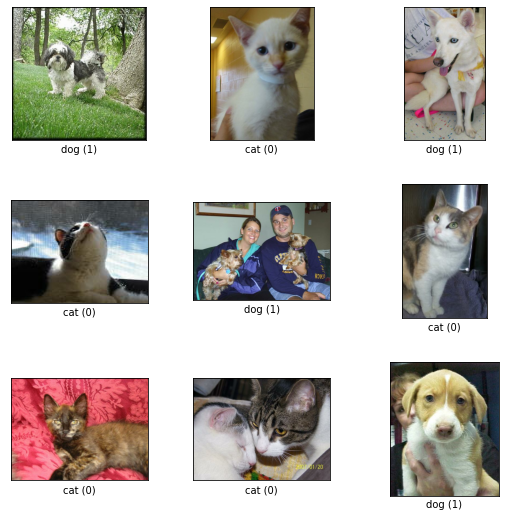

In [158]:
fig = tfds.show_examples(ds_train, ds_info)

## ResNet34 과 Plain 34 ,  ResNet50 과 Plain 50 비교하기

In [159]:
BATCH_SIZE = 32
EPOCH = 10

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [160]:
resnet34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)


plain_resnet34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)


resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)


plain_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)





history_resnet34 = resnet34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[20%:]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[:20%]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)


history_plain34 = plain_resnet34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[20%:]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[:20%]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)




history_resnet50 = resnet50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[20%:]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[:20%]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)


history_plain50 = plain_resnet50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[20%:]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[:20%]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
581/581 [==============================] - 260s 423ms/step - loss: 0.0393 - accuracy: 0.9896 - val_loss: 0.8712 - val_accuracy: 0.7292
Epoch 2/10
581/581 [==============================] - 245s 422ms/step - loss: 0.0283 - accuracy: 0.9927 - val_loss: 0.9549 - val_accuracy: 0.7299
Epoch 3/10
581/581 [==============================] - 245s 422ms/step - loss: 0.0214 - accuracy: 0.9945 - val_loss: 1.0175 - val_accuracy: 0.7237
Epoch 4/10
581/581 [==============================] - 245s 422ms/step - loss: 0.0087 - accuracy: 0.9991 - val_loss: 1.0415 - val_accuracy: 0.7390
Epoch 5/10
581/581 [==============================] - 245s 422ms/step - loss: 0.0039 - accuracy: 0.9997 - val_loss: 1.0209 - val_accuracy: 0.7405
Epoch 6/10
581/581 [==============================] - 245s 422ms/step - loss: 0.0035 - accuracy: 0.9994 - val_loss: 1.0600 - val_accuracy: 0.7375
Epoch 7/10
581/581 [==============================] - 246s 423ms/step - loss: 0.0019 - accuracy: 0.9997 - val_loss: 1.0742 -

### ResNet34, Plain34 비교

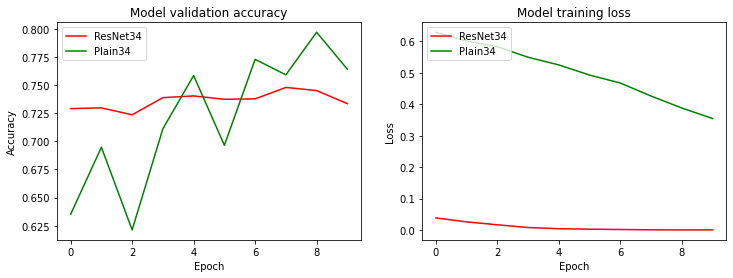

In [162]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1,2,1)
plt.plot(history_resnet34.history['val_accuracy'], 'r')
plt.plot(history_plain34.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet34', 'Plain34'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_resnet34.history['loss'], 'r')
plt.plot(history_plain34.history['loss'], 'g')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet34', 'Plain34'], loc='upper left')



plt.show()

### ResNet50, Plain50 비교

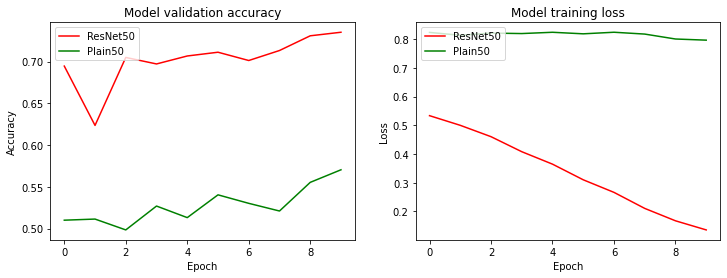

In [163]:
plt.figure(figsize=(12, 4))

plt.subplot(1,2,1)
plt.plot(history_resnet50.history['val_accuracy'], 'r')
plt.plot(history_plain50.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet50', 'Plain50'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_resnet50.history['loss'], 'r')
plt.plot(history_plain50.history['loss'], 'g')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet50', 'Plain50'], loc='upper left')



plt.show()